# Dask start

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:53318")
client

<Client: 'tcp://127.0.0.1:53318' processes=4 threads=8, memory=16.00 GiB>

# Import

In [2]:
import sys
sys.path.insert(1, '..')
from pathlib import Path

In [3]:
#import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import gsw
from xhistogram.xarray import histogram
from dask import compute
import pandas as pd
import cartopy.crs as ccrs
import xgcm
from xorca.lib import load_xorca_dataset, preprocess_orca
from scipy import ndimage

In [4]:
%load_ext memory_profiler

# Plotting params

In [5]:
#%matplotlib widget
%matplotlib inline

In [6]:
line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4']

In [7]:
cmaps_list = ['Blues', 'Oranges', 'Greens', 'Reds']

# Load data

In [8]:
%%time
%%memit
quantity = 'votemper'
ds_test = xr.open_mfdataset('/Users/ana/data/QBOX/eNATL60QBOX3-BLB002_1h_20090710_20090714_' + quantity +'_20090714-20090714.nc', parallel=True)

peak memory: 182.50 MiB, increment: 0.84 MiB
CPU times: user 94.1 ms, sys: 45.1 ms, total: 139 ms
Wall time: 1.21 s


In [9]:
data_path = Path("/Users/ana/data/QBOX/")
# data_files = list(sorted(data_path.glob("eNATL60QBOX3*nc")))
data_files = [Path('/Users/ana/data/QBOX/eNATL60QBOX3-BLB002_1h_20090710_20090714_sossheig_20090714-20090714.nc'),
 Path('/Users/ana/data/QBOX/eNATL60QBOX3-BLB002_1h_20090710_20090714_vosaline_20090714-20090714.nc'),
 Path('/Users/ana/data/QBOX/eNATL60QBOX3-BLB002_1h_20090710_20090714_votemper_20090714-20090714.nc'),
 Path('/Users/ana/data/QBOX/eNATL60QBOX3-BLB002_1h_20090710_20090714_vomecrty_20090714-20090714.nc'),
 Path('/Users/ana/data/QBOX/eNATL60QBOX3-BLB002_1h_20090710_20090714_vozocrtx_20090714-20090714.nc')]
# data_files.append(data_path / "new_maskglo.nc")
aux_files = [Path('/Users/ana/data/QBOX/mask_eNATL60QBOX3.nc'),
 Path('/Users/ana/data/QBOX/mesh_hgr_eNATL60QBOX3.nc')]

In [10]:
#ds = xr.open_mfdataset(data_files,
#                       preprocess=(lambda ds:
#                                   preprocess_orca(data_path / "mesh_hgr_eNATL60QBOX3.nc", ds)))
#ds = ds.chunk({"t": 1, "z_c": 23, "z_l": 23})
#ds

In [11]:
%%time
ds = load_xorca_dataset(data_files=data_files, aux_files=aux_files,
                              decode_cf=True,
                              input_ds_chunks={"time_counter": 6, "t": 6,
                                               "z": 14, "Z": 14,
                                               "deptht": 14, "depthu": 14,
                                               "depthv": 14, "depthw": 14,
                                               "y": 245, "Y": 245,
                                               "x": 400, "X": 400},
                              target_ds_chunks={"t": 6,
                                                "z_c": 14, "z_l": 14,
                                                "y_c": 245, "y_r": 245,
                                                "x_c": 400, "x_r": 400})

CPU times: user 258 ms, sys: 12.6 ms, total: 271 ms
Wall time: 275 ms


In [12]:
ds = ds.isel(t=[0,-1,6])

In [13]:
ds.coords['depth_c'] = xr.DataArray(ds_test['deptht'].values, dims='z_c')

In [14]:
ds.coords['depth_l'] = xr.DataArray(xgcm.autogenerate.generate_grid_ds(ds, {'Z':'depth_c'}).depth_c_left.values, dims='z_l')

In [15]:
print(ds.nbytes / 1e9, "GiB")

8.84680432 GiB


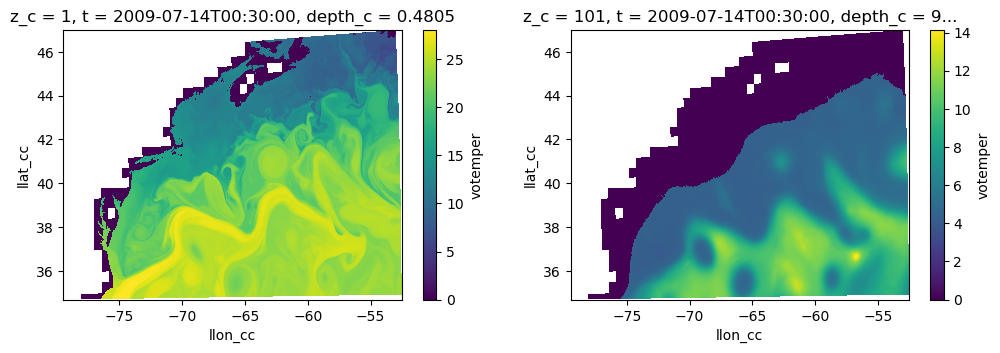

peak memory: 515.28 MiB, increment: 311.41 MiB
CPU times: user 828 ms, sys: 133 ms, total: 961 ms
Wall time: 5.28 s


In [16]:
%%time
%%memit
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,3.5))
ds.votemper.isel(t=0, z_c=0).plot(x='llon_cc', y='llat_cc',ax=ax[0])
ds.votemper.isel(t=0, z_c=100).plot(x='llon_cc', y='llat_cc', ax=ax[1])
plt.show()

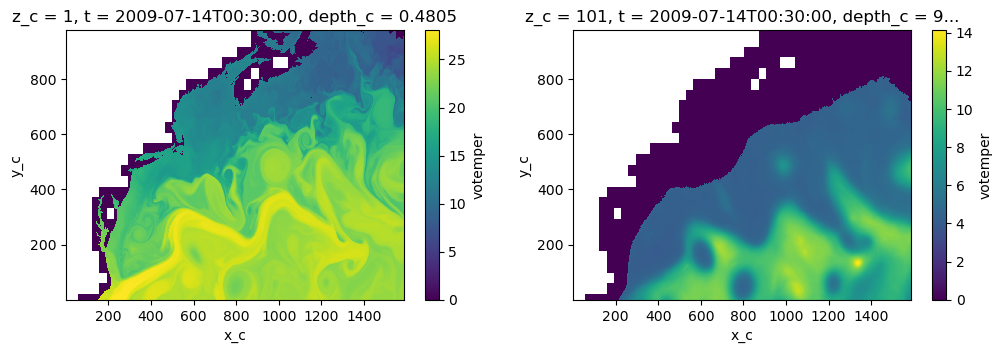

peak memory: 659.44 MiB, increment: 141.75 MiB
CPU times: user 800 ms, sys: 109 ms, total: 909 ms
Wall time: 5.11 s


In [17]:
%%time
%%memit
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,3.5))
ds.votemper.isel(t=0, z_c=0).plot(ax=ax[0])
ds.votemper.isel(t=0, z_c=100).plot(ax=ax[1])
plt.show()

# Grid metrics

In [18]:
ds.coords['area_t'] = ds['e1t']*ds['e2t']
ds.coords['area_u'] = ds['e1u']*ds['e2u']
ds.coords['area_v'] = ds['e1v']*ds['e2v']
ds.coords['area_f'] = ds['e1f']*ds['e2f']

In [19]:
metrics = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
    ('X', 'Y',): ['area_t', 'area_u', 'area_v', 'area_f'] # Areas 
}

In [20]:
grid = xgcm.Grid(ds, metrics=metrics, periodic=False, coords={'X' : {'center' : 'x_c', 'right' : 'x_r'}, \
                                                              'Y' : {'center' : 'y_c', 'right' : 'y_r'},
                                                              'Z' : {'center' : 'z_c', 'left' : 'z_l'}})

In [21]:
grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   x_c --> right
  * right    x_r --> center
Y Axis (not periodic, boundary=None):
  * center   y_c --> right
  * right    y_r --> center
Z Axis (not periodic, boundary=None):
  * center   z_c --> left
  * left     z_l --> center

In [22]:
# Calculate vertical distances located on the cellboundary
ds.coords['dzc'] = grid.diff(ds.depth_c, 'Z', boundary='fill', fill_value=np.NaN)
# Calculate vertical distances located on the cellcenter
ds.coords['dzt'] = grid.diff(ds.depth_l, 'Z', boundary='fill', fill_value=np.NaN)

In [23]:
ds

<xarray.Dataset>
Dimensions:   (z_c: 107, z_l: 107, y_c: 976, y_r: 976, x_c: 1588, x_r: 1588,
               t: 3)
Coordinates: (12/35)
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 ... 100 101 102 103 104 105 106 107
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 103.5 104.5 105.5 106.5
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 ... 969 970 971 972 973 974 975 976
  * y_r       (y_r) float64 1.5 2.5 3.5 4.5 5.5 ... 973.5 974.5 975.5 976.5
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 ... 1582 1583 1584 1585 1586 1587 1588
  * x_r       (x_r) float64 1.5 2.5 3.5 4.5 ... 1.586e+03 1.588e+03 1.588e+03
    ...        ...
    area_t    (y_c, x_c) float64 dask.array<chunksize=(245, 400), meta=np.ndarray>
    area_u    (y_c, x_r) float64 dask.array<chunksize=(245, 400), meta=np.ndarray>
    area_v    (y_r, x_c) float64 dask.array<chunksize=(245, 400), meta=np.ndarray>
    area_f    (y_r, x_r) float64 dask.array<chunksize=(245, 400), meta=np.ndarray>
    dzc       (z_l) float32 nan 1.078 1.235 1.393 ... 16.69 16.81 16.93 17.04
    dzt       (z_c) float32 1.078 1.157 1.314 1.472 ... 16.75 16.87 16.98 nan
Data variables:
    somxl010  (t, y_c, x_c) float32 dask.array<chunksize=(1, 245, 400), meta=np.ndarray>
    sosaline  (t, y_c, x_c) float32 dask.array<chunksize=(1, 245, 400), meta=np.ndarray>
    sossheig  (t, y_c, x_c) float32 dask.array<chunksize=(1, 245, 400), meta=np.ndarray>
    sosstsst  (t, y_c, x_c) float32 dask.array<chunksize=(1, 245, 400), meta=np.ndarray>
    vomecrty  (t, z_c, y_r, x_c) float32 dask.array<chunksize=(1, 14, 245, 400), meta=np.ndarray>
    vosaline  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 14, 245, 400), meta=np.ndarray>
    votemper  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 14, 245, 400), meta=np.ndarray>
    vozocrtx  (t, z_c, y_c, x_r) float32 dask.array<chunksize=(1, 14, 245, 400), meta=np.ndarray>

# Density

Compute sea pressure

In [24]:
# NOT to forget minus in front of z
ds['pressure'] = xr.apply_ufunc(gsw.conversions.p_from_z, -ds.z_c, ds.llat_cc, dask='parallelized')

Compute density

In [25]:
ds['rho'] = xr.apply_ufunc(gsw.density.rho, ds.vosaline, ds.votemper, ds.pressure, dask='parallelized')
ds['sigma0'] = xr.apply_ufunc(gsw.density.sigma0, ds.vosaline, ds.votemper, dask='parallelized')

## Vertical profiles

In [26]:
select_point = {'x_c' : -200, 'y_c' : -200}
select_time = {'t' : 1}

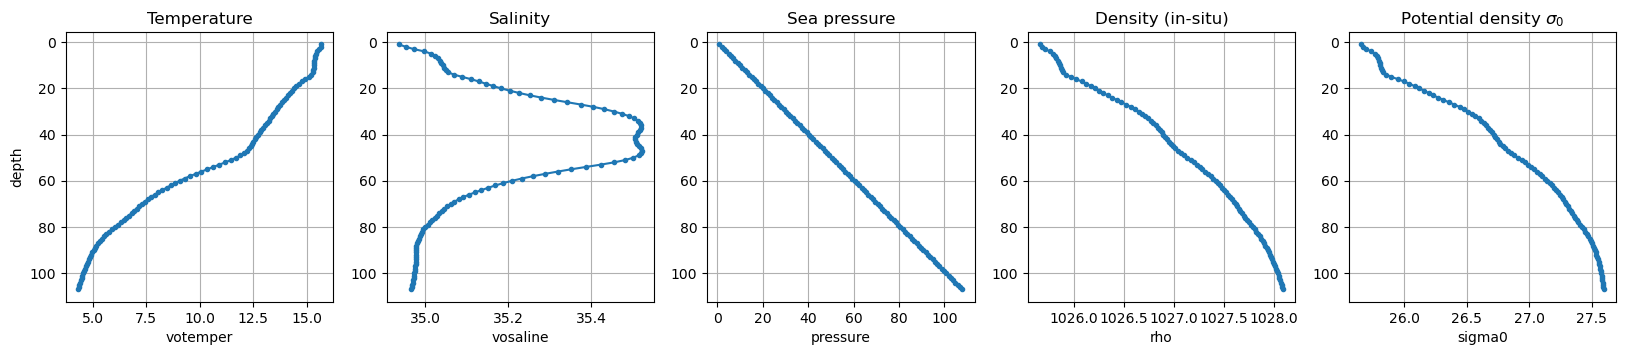

In [27]:
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(20,3.5))
ds['votemper'].isel(select_time | select_point).plot(ax=ax[0],y='z_c', marker='.')
ds['vosaline'].isel(select_time | select_point).plot(ax=ax[1],y='z_c', marker='.')
ds['pressure'].isel(select_point).plot(ax=ax[2],y='z_c', marker='.')
ds['rho'].isel(select_time | select_point).plot(ax=ax[3],y='z_c', marker='.')
ds['sigma0'].isel(select_time | select_point).plot(ax=ax[4],y='z_c', marker='.')
ax[0].set(title='Temperature')
ax[1].set(title='Salinity')
ax[2].set(title='Sea pressure')
ax[3].set(title='Density (in-situ)')
ax[4].set(title=r'Potential density $\sigma_0$')
for axis in ax :
    axis.set(ylabel='')
    axis.invert_yaxis(); axis.grid(True)
ax[0].set(ylabel='depth')
plt.show()

## Vertical gradients

In [28]:
ds['dz_temp'] = grid.diff(ds.votemper, axis='Z', boundary='extend')/ds.coords['dzc']
ds['dz_sal'] = grid.diff(ds.vosaline, axis='Z', boundary='extend')/ds.coords['dzc']
ds['dz_rho'] = grid.diff(ds.rho, axis='Z', boundary='extend')/ds.coords['dzc']

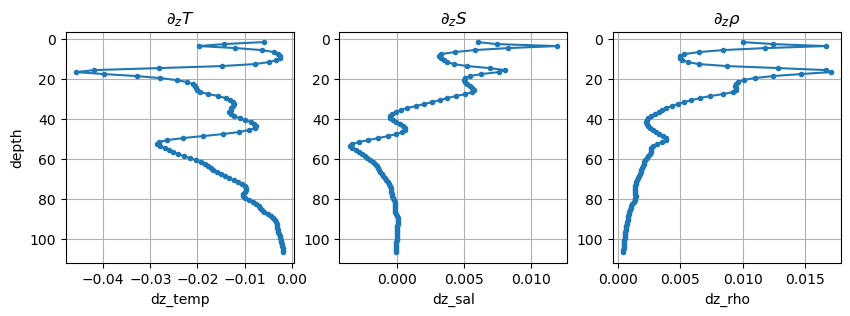

peak memory: 543.62 MiB, increment: 1.58 MiB
CPU times: user 274 ms, sys: 37.4 ms, total: 311 ms
Wall time: 10.6 s


In [29]:
%%time
%%memit
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10,3))
ds['dz_temp'].isel(select_point).mean(dim='t').plot(ax=ax[0],y='z_l', marker='.')
ds['dz_sal'].isel(select_point).mean(dim='t').plot(ax=ax[1],y='z_l', marker='.')
ds['dz_rho'].isel(select_point).mean(dim='t').plot(ax=ax[2],y='z_l', marker='.')
ax[0].set(title=r'$\partial_z T $')
ax[1].set(title=r'$\partial_z S $')
ax[2].set(title=r'$\partial_z \rho $')
for axis in ax :
    axis.set(ylabel='')
    axis.invert_yaxis(); axis.grid(True)
ax[0].set(ylabel='depth')
plt.show()

## Horizontal gradients of density

In [30]:
ds['dx_rho'] = grid.derivative(ds.rho, axis='X', boundary='extend')
ds['dy_rho'] = grid.derivative(ds.rho, axis='Y', boundary='extend')

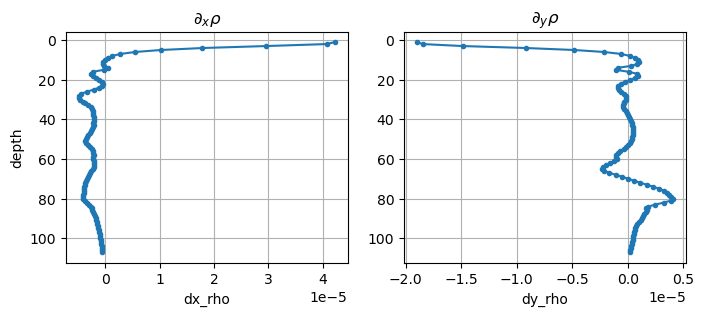

peak memory: 538.67 MiB, increment: 3.09 MiB
CPU times: user 285 ms, sys: 31.5 ms, total: 316 ms
Wall time: 13.6 s


In [31]:
%%time
%%memit
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,3))
grid.interp(ds['dx_rho'], axis='X').isel(select_time | select_point).plot(ax=ax[0],y='z_c', marker='.')
grid.interp(ds['dy_rho'], axis='Y').isel(select_time | select_point).plot(ax=ax[1],y='z_c', marker='.')
ax[0].set(title=r'$\partial_x \rho $')
ax[1].set(title=r'$\partial_y \rho $')
for axis in ax :
    axis.set(ylabel='')
    axis.invert_yaxis(); axis.grid(True)
ax[0].set(ylabel='depth')
plt.show()

# Horizontal gradient of pressure

In [32]:
g = 9.80665 
rho_0 = 1023.6 # reference density

## Surface gradient

In [33]:
ds['rho_surface'] = xr.DataArray((grid.interp(ds.rho, axis='Z').isel(z_l=0).drop('z_l')), dims=['t', 'y_c', 'x_c'])
ds['dx_p_surface'] = grid.interp(g/rho_0*grid.derivative(ds.rho_surface*ds.sossheig, axis='X', boundary='extend'), axis='X')    
ds['dy_p_surface'] = grid.interp(g/rho_0*grid.derivative(ds.rho_surface*ds.sossheig, axis='Y', boundary='extend'), axis='Y')     

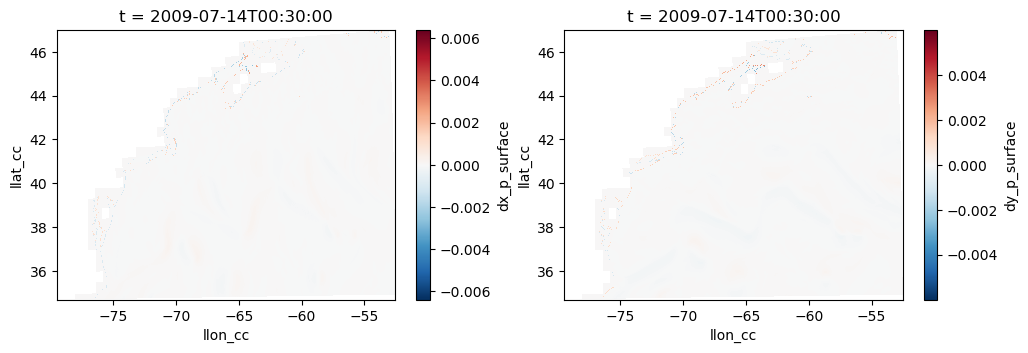

peak memory: 434.72 MiB, increment: 42.39 MiB
CPU times: user 974 ms, sys: 189 ms, total: 1.16 s
Wall time: 28 s


In [34]:
%%time
%%memit
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,3.5))
ds.dx_p_surface.isel(t=0).plot(x='llon_cc', y='llat_cc', ax=ax[0])
ds.dy_p_surface.isel(t=0).plot(x='llon_cc', y='llat_cc', ax=ax[1])
plt.show()

## Interior gradient

In [35]:
# ds['dx_p'] = g/rho_0*grid.cumint(grid.interp(ds.dx_rho, axis=['X', 'Z'], boundary='extend'), axis='Z')
# ds['dy_p'] = g/rho_0*grid.cumint(grid.interp(ds.dy_rho, axis=['Y', 'Z'], boundary='extend'), axis='Z')

ds['dx_p'] = grid.interp(g/rho_0*grid.cumsum(ds.dx_rho*ds.dzt, axis='Z'), axis={'X','Z'})
ds['dy_p'] = grid.interp(g/rho_0*grid.cumsum(ds.dy_rho*ds.dzt, axis='Z'), axis={'Y','Z'})

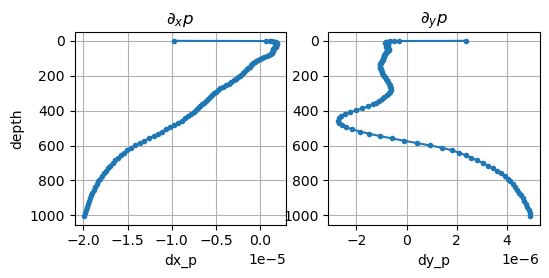

In [46]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(6,2.5))
ds['dx_p'].isel(select_time | select_point).plot(ax=ax[0],y='depth_c', marker='.')
ds['dy_p'].isel(select_time | select_point).plot(ax=ax[1],y='depth_c', marker='.')
ax[0].set(title=r'$\partial_x p $')
ax[1].set(title=r'$\partial_y p $')
for axis in ax :
    axis.set(ylabel='')
    axis.invert_yaxis(); axis.grid(True)
ax[0].set(ylabel='depth')
plt.show()

# Geostrophy

## Coriolis force

In [37]:
# Coriolis parameter
ds['f'] = xr.apply_ufunc(gsw.geostrophy.f, ds.llat_cc, dask='parallelized')

In [38]:
ds['coriolis_x_dir'] = ds.f*grid.interp(ds['vomecrty'], axis='Y', boundary='extend')
ds['coriolis_y_dir'] = ds.f*grid.interp(ds['vozocrtx'], axis='X', boundary='extend')

## Geostrophical balance

In 1 point at 1 time instant:

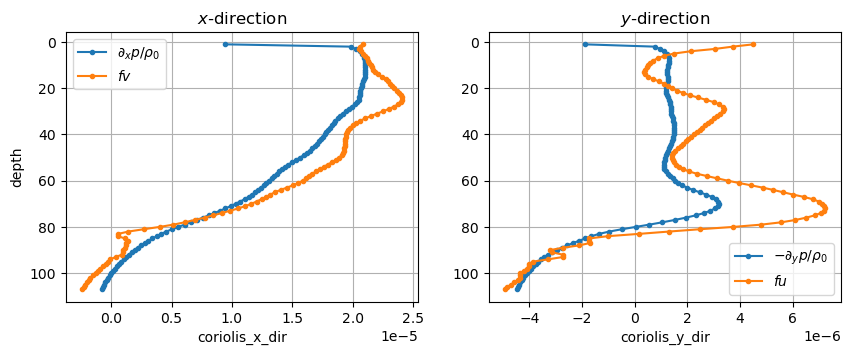

peak memory: 197.47 MiB, increment: 4.27 MiB
CPU times: user 357 ms, sys: 81.3 ms, total: 438 ms
Wall time: 19.7 s


In [39]:
%%time
%%memit
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,3.5))
(ds['dx_p']+ds['dx_p_surface']).isel(select_time | select_point).plot(ax=ax[0],y='z_c', marker='.', label=r'$\partial_x p/\rho_0$')
(-ds['dy_p']-ds['dy_p_surface']).isel(select_time | select_point).plot(ax=ax[1],y='z_c', marker='.', label=r'$-\partial_y p/\rho_0$')
ds['coriolis_x_dir'].isel(select_time | select_point).plot(ax=ax[0],y='z_c', marker='.', label=r'$f v$')
ds['coriolis_y_dir'].isel(select_time | select_point).plot(ax=ax[1],y='z_c', marker='.', label=r'$f u$')
ax[0].set(title=r'$x$-direction')
ax[1].set(title=r'$y$-direction')
for axis in ax :
    axis.set(ylabel='')
    axis.invert_yaxis(); axis.grid(True)
    axis.legend()
ax[0].set(ylabel='depth')
plt.show()

Averaged over a horizontal area of 200x200 pixels in space and in time:

In [40]:
select_area = {'x_c' : slice(1200,1400), 'y_c' : slice(None,200)}

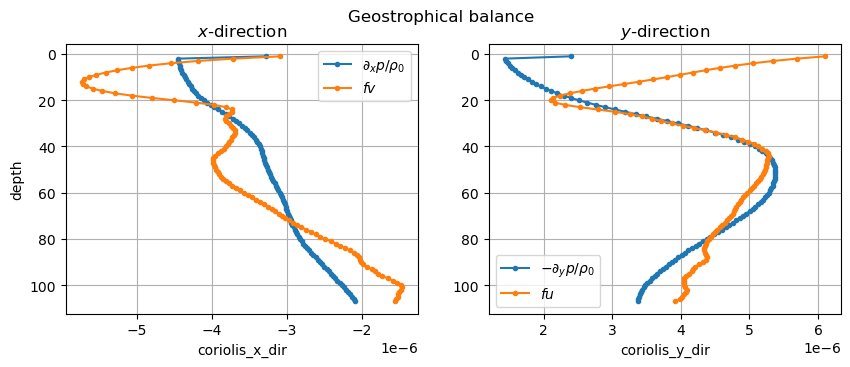

peak memory: 207.12 MiB, increment: 10.41 MiB
CPU times: user 725 ms, sys: 130 ms, total: 856 ms
Wall time: 1min 54s


In [41]:
%%time
%%memit
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,3.5))
fig.suptitle(r'Geostrophical balance')
grid.average((ds['dx_p']+ds['dx_p_surface']).isel(select_area), axis=['X', 'Y']).mean(dim='t').plot(ax=ax[0],y='z_c', marker='.', label=r'$\partial_x p/\rho_0$')
grid.average((ds['coriolis_x_dir']).isel(select_area), axis=['X', 'Y']).mean(dim='t').plot(ax=ax[0],y='z_c', marker='.', label=r'$fv$')
grid.average((-ds['dy_p']-ds['dy_p_surface']).isel(select_area), axis=['X', 'Y']).mean(dim='t').plot(ax=ax[1],y='z_c', marker='.', label=r'$-\partial_y p/\rho_0$')
grid.average((ds['coriolis_y_dir']).isel(select_area), axis=['X', 'Y']).mean(dim='t').plot(ax=ax[1],y='z_c', marker='.', label=r'$fu$')
ax[0].set(title=r'$x$-direction')
ax[1].set(title=r'$y$-direction')
for axis in ax :
    axis.set(ylabel='')
    axis.invert_yaxis(); axis.grid(True)
    axis.legend()
ax[0].set(ylabel='depth')
plt.show()

# EOS density derivatives

In [42]:
# problem with implementation of second serivatives in gsw: does not work with xarray output
temp_array = gsw.rho_second_derivatives(ds.vosaline.values, ds.votemper.values, ds.pressure.values)
ds['rho_sa_sa'] = xr.DataArray(temp_array[0], dims=['t','z_c', 'y_c', 'x_c'])
ds['rho_sa_ct'] = xr.DataArray(temp_array[1], dims=['t','z_c', 'y_c', 'x_c'])
ds['rho_ct_ct'] = xr.DataArray(temp_array[2], dims=['t','z_c', 'y_c', 'x_c'])
ds['rho_sa_p'] = xr.DataArray(temp_array[3], dims=['t','z_c', 'y_c', 'x_c'])
ds['rho_ct_p'] = xr.DataArray(temp_array[4], dims=['t','z_c', 'y_c', 'x_c'])

del temp_array

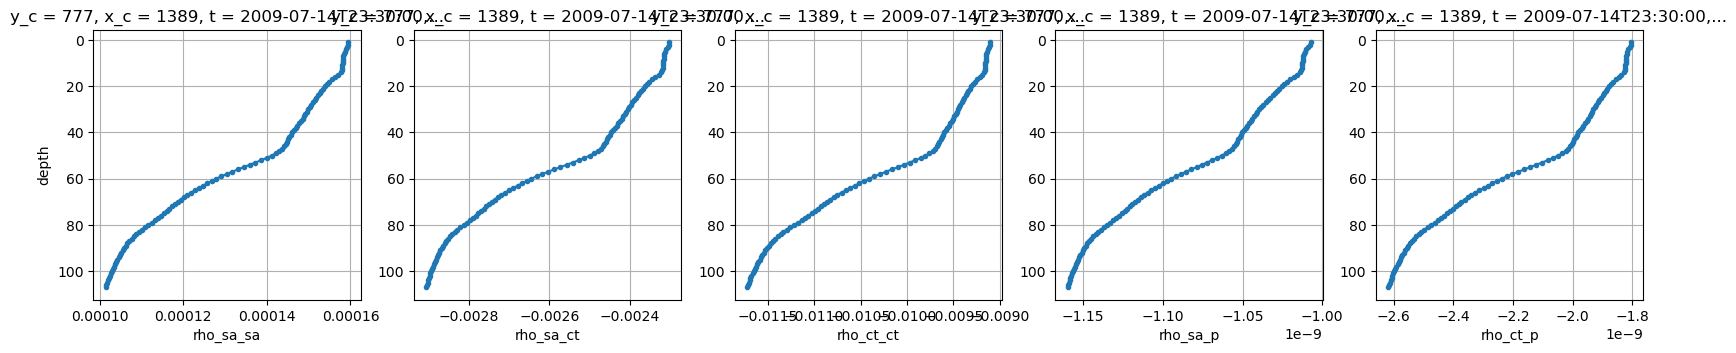

peak memory: 719.14 MiB, increment: 21.39 MiB
CPU times: user 287 ms, sys: 79 ms, total: 366 ms
Wall time: 1.38 s


In [43]:
%%time
%%memit
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(20,3.5))
ds['rho_sa_sa'].isel(select_time | select_point).plot(ax=ax[0],y='z_c', marker='.')
ds['rho_sa_ct'].isel(select_time | select_point).plot(ax=ax[1],y='z_c', marker='.')
ds['rho_ct_ct'].isel(select_time | select_point).plot(ax=ax[2],y='z_c', marker='.')
ds['rho_sa_p'].isel(select_time | select_point).plot(ax=ax[3],y='z_c', marker='.')
ds['rho_ct_p'].isel(select_time | select_point).plot(ax=ax[4],y='z_c', marker='.')
for axis in ax :
    axis.set(ylabel='')
    axis.invert_yaxis(); axis.grid(True)
ax[0].set(ylabel='depth')
plt.show()